# Training a Convolutional Neural Network for CIFAR data with FishLeg vs Adam

In this example notebook, we'll guide you through the processing of training a CNN with Adam and FishLeg optimizers and getting results.

## Step 0: Import necessary packages

In [1]:
!pip install -q -r requirements.txt 
!pip install -q pandas

In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm


import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from utils import class_accuracy
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from data_utils import read_data_sets, get_MNIST, get_cifar

torch.set_default_dtype(torch.float32)

sys.path.append("../src")

from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel


from torchsummary import summary
import copy
import pandas as pd


/home/xzcapwsl/.conda/envs/fishlegnotebook/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_90671/1550202021.py:29: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Step 1: Set up GPU environment for model training

This is to ensure that if a GPU is available it will be used for training

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

seed = 13
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on", device)

Running on cpu


## Step 2: Construct the function for training model

The following function is written to take in different models and train them on the given dataset.
The training is done using the choice of optimiser with the `opt` variable



In [4]:
def train_model(model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=100, device='cuda', savedir=False):
    '''
    Function to train model and obtain metrics per step and per epoch

    Inputs:
        model: model to train
        train_loader: training data loader
        test_loader: test data loader
        opt: optimiser
        likelihood: likelihood function
        epochs: number of epochs to train for
        device: device to train on

    Outputs:
        model: trained model
        train_df_per_step: dataframe of training loss, accuracy and time per step
        test_df_per_step: dataframe of test loss, accuracy and time per step
        df_per_epoch: dataframe of training and test loss, accuracy and time per epoch 
    '''
    train_df_per_step = pd.DataFrame(columns=['loss', 'acc', 'step_time', 'aux_loss'])
    test_df_per_step = pd.DataFrame(columns=['loss', 'acc'])
    df_per_epoch = pd.DataFrame(columns=['train_loss', 'train_acc', 'epoch_time', 'test_loss', 'test_acc'])
    st = time.time()
    eval_time = 0

    for epoch in range(1, epochs + 1):
        with tqdm(train_loader, unit="batch") as tepoch:
            running_loss = 0
            running_acc = 0
            running_aux_loss = 0
            for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
                tepoch.set_description(f"Epoch {epoch}")

                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                opt.zero_grad()
                output = model(batch_data)

                loss = likelihood(output, batch_labels)

                running_loss += loss.item()
                running_acc += class_accuracy(output, batch_labels).item()

                loss.backward()
                opt.step()

                et = time.time()     
                try:
                    aux_loss = opt.aux_loss
                    if aux_loss != np.nan:
                        running_aux_loss += opt.aux_loss
                    df_temp = pd.DataFrame([[loss.item(), class_accuracy(output, batch_labels).item(), et-st, aux_loss]], columns=['loss', 'acc', 'step_time', 'aux_loss'])

                except:
                    df_temp = pd.DataFrame([[loss.item(), class_accuracy(output, batch_labels).item(), et-st]], columns=['loss', 'acc', 'step_time'])

                if train_df_per_step.empty:
                    train_df_per_step = df_temp
                else:
                    train_df_per_step = pd.concat([train_df_per_step, df_temp], ignore_index=True)

                if n % 50 == 0:
                    model.eval()

                    running_test_loss = 0
                    running_test_acc = 0

                    for m, (test_batch_data, test_batch_labels) in enumerate(test_loader, start=1):
                        test_batch_data, test_batch_labels = test_batch_data.to(device), test_batch_labels.to(device)

                        test_output = model(test_batch_data)

                        test_loss = likelihood(test_output, test_batch_labels)

                        running_test_loss += test_loss.item()
                        running_test_acc += class_accuracy(test_output, test_batch_labels).item()

                        df_temp = pd.DataFrame([[test_loss.item(), class_accuracy(test_output, test_batch_labels).item()]], columns=['loss', 'acc'])
                        if test_df_per_step.empty:
                            test_df_per_step = df_temp
                        else:
                            test_df_per_step = pd.concat([test_df_per_step, df_temp], ignore_index=True)

                    running_test_loss /= m
                    running_test_acc /= m

                    tepoch.set_postfix(acc=100 * running_acc / n, test_acc=running_test_acc * 100)
                    model.train()
                    eval_time += time.time() - et
            
            epoch_time = time.time() - st - eval_time
            tepoch.set_postfix(loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time)


            df_temp = pd.DataFrame([[running_loss / n, 100 * running_acc / n, epoch_time, running_test_loss, 100 * running_test_acc, running_aux_loss/n]], columns=['train_loss', 'train_acc', 'epoch_time', 'test_loss', 'test_acc', 'aux_loss'])

            if df_per_epoch.empty:
                df_per_epoch = df_temp
            else:
                df_per_epoch = pd.concat([df_per_epoch, df_temp], ignore_index=True)

            if savedir:
                if not os.path.exists(savedir):
                    os.makedirs(savedir)
                    os.makedirs(f"{savedir}/ckpts")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                    'metrics': df_per_epoch,
                    }, f"{savedir}/ckpts/epoch={epoch}-test_loss={round(running_test_loss, 4)}.pt")

    return model, train_df_per_step, test_df_per_step, df_per_epoch


## Step 3: Reading in MNIST data

First the data has to be loaded using the `read_data_sets` helper function

In [5]:
dataset = get_cifar("../data/", if_autoencoder=False)

## Dataset
train_dataset = dataset.train
test_dataset = dataset.test
print()
# Use len() to get the number of examples
print("Number of training samples: ", len(train_dataset))
print("Number of testing samples: ", len(test_dataset))

# Accessing the shape of the images
# Assuming your dataset returns a tuple of (image, label), you can get the shape of the first image as an example
# This line may need to be adjusted depending on how your dataset is structured
print("Image shape: ", train_dataset[0][0].shape)

Files already downloaded and verified
Files already downloaded and verified

Number of training samples:  50000
Number of testing samples:  10000
Image shape:  torch.Size([3, 32, 32])


In [6]:
def plot_images(dataset, n_images):
    '''
    Function to plot images from CIFAR dataset
    Inputs:
        dataset: CIFAR dataset
        n_images: number of images to plot
    '''
    fig, axs = plt.subplots(1, n_images, figsize=(n_images * 2, 2))
    if n_images == 1:  
        axs = [axs]
    for i, ax in enumerate(axs):
        img = dataset[i][0]
        label = dataset[i][1]
        if img.shape[0] == 3: 
            img = img.permute(1, 2, 0)  

        ax.imshow(img)
        ax.axis('off')
        
    plt.show()

### Plot example CIFAR data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


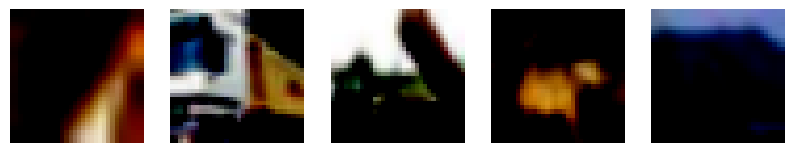

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


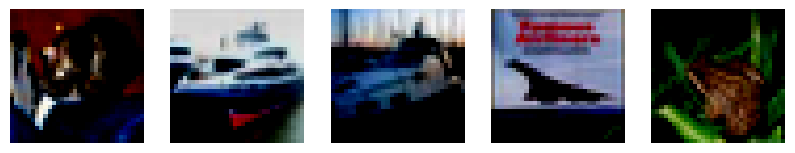

In [7]:
plot_images(train_dataset, 5)
plot_images(test_dataset, 5)

# Step 4: Set up training and testing dataloader.

Note that an additional aux_loader is defined. This is used to calculate the auxiliary loss when using FishLeg optimiser

In [8]:
batch_size = 500


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

aux_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Step 5: Initialise the model

The following code constructs a vanilla CNN model

To use FishLeg optimiser, the model has to be slightly modified so that it contains additional parameters necessary.
<br>
This could be done by just passing through the initialised model through the helper funcion `initialise_FishModel`.
<br>
This modified model can be shown by using `summary` function, both models have the same architecture but the layer name for the FishLeg model is renamed.

In [9]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=3,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(
        in_channels=16,
        out_channels=32,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(8 * 16 * 16, 10),
)



adam_model = copy.deepcopy(model)

scale_factor = 1
damping = 0.1
fishleg_model = initialise_FishModel(
    copy.deepcopy(model), module_names="__ALL__", fish_scale=scale_factor / damping
)

### Adam CNN summary

In [10]:
summary(adam_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]          12,832
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                   [-1, 10]          20,490
Total params: 34,538
Trainable params: 34,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 0.13
Estimated Total Size (MB): 0.58
----------------------------------------------------------------


### FishLeg CNN summary

In [11]:
summary(fishleg_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        FishConv2d-1           [-1, 16, 32, 32]           1,216
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
        FishConv2d-4           [-1, 32, 16, 16]          12,832
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
           Flatten-7                 [-1, 2048]               0
        FishLinear-8                   [-1, 10]          20,490
Total params: 34,538
Trainable params: 34,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 0.13
Estimated Total Size (MB): 0.58
----------------------------------------------------------------


## Step 6: Training with Adam

The work flow:

- We specify a custom implementation of softmax likelihood which defines the way to compute loss in our classification tasks.
- We then specify the hyperparameters: Learning rate, weight decay and optimizers.
- Lastly, we train the model with these hyperparameters and the data specified above.


Hyperparameters:

- Learning rate: Controls the step size in updating weights during training.
- Weight decay: Adds a penalty on large weights to reduce overfitting and improve model generalization.
- Optimizer: An algorithm that adjusts weights adaptively for each parameter to minimize the loss function more efficiently.

Outputs:

- Trained model
- 3 pandas dataframe:
    - train_df_per_step: contains metrics on training data per step (ie training loss, training accuracy, time taken at each step)
    - test_df_per_step: contains metrics on testing data per step (ie testing loss, testing accuracy)
    - df_per_epoch: contains metrics on training and testing data per epoch ((ie training/testing loss, training/tesing accuracy, time taken at each epoch))


In [12]:
likelihood = FISH_LIKELIHOODS["softmax"](device=device)

lr = 0.0005
weight_decay = 1e-5
epoch = 100

opt = optim.Adam(
    adam_model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
# savedir=None
savedir = f"runs/CIFAR_adam/lr={lr}_lambda={weight_decay}/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
adam_trained_model, adam_train_df_per_step, adam_test_df_per_step, adam_df_per_epoch = train_model(adam_model, train_loader, test_loader, opt, likelihood,class_accuracy, epochs=epoch, device=device, savedir=savedir)


Epoch 100: 100%|██████████| 100/100 [00:29<00:00,  3.39batch/s, acc=57.4, test_acc=67] 


## Step 7: Training with FishLeg

The workflow:

- We specify all the hyperparameters(learning rate, weight_decay,etc).
- We initialise a model with replacement of certain layers with corresponding 'FishLeg' layers
- We specify the FishLeg optimizer
- Lastly, we train the model


Hyperparameters:

- Learning rate: Controls the step size in updating weights during training.
- Weight decay: Adds a penalty on large weights to reduce overfitting and improve model generalization.
- Optimizer: An algorithm that adjusts weights adaptively for each parameter to minimize the loss function more efficiently.
- beta: coefficient for running averages of gradient (default: 0.9)
- aux_lr: learning rate for the auxiliary parameters, using Adam (default: 1e-3)
- aux_eps: Term added to the denominator to improve numerical stability for auxiliary parameters (default: 1e-8)
- damping: Static damping applied to Fisher matrix, :math:\gamma,for stability when FIM becomes near-singular. (default: 5e-1)

Outputs are similar to adam but with an additional auxiliary loss in the train_df_per_step dataframe

In [13]:
lr = 0.02
beta = 0.9
weight_decay = 1e-5
likelihood = FISH_LIKELIHOODS["softmax"](device=device)
aux_lr = 1e-4
aux_eps = 1e-8
scale_factor = 1
damping = 0.1
update_aux_every = 3

initialization = "normal"
normalization = True

epoch = 100

In [14]:
print(len(opt.state_dict()['state']))  # This should match the number of model parameters
print(len(list(fishleg_model.parameters())))  # This prints the number of model parameters

# Verify each parameter group if using them
for group in opt.param_groups:
    for p in group['params']:
        if p.requires_grad:
            print(p.shape)


6
15
torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([10, 2048])
torch.Size([10])


In [15]:
opt1 = FishLeg(
    fishleg_model,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
    aux_log = True,
)


In [16]:
# savedir=None
savedir = f"runs/CIFAR_fishleg/lr={lr}_lambda={weight_decay}/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
fishleg_trained_model, fishleg_train_df_per_step, fishleg_test_df_per_step, fishleg_df_per_epoch = train_model(fishleg_model, train_loader, test_loader, opt1, likelihood,class_accuracy, epochs=epoch, device=device, savedir=savedir)

Epoch 100: 100%|██████████| 100/100 [00:44<00:00,  2.25batch/s, acc=62.1, test_acc=72.6]


## Plot for comparison between Adam and FishLeg

Text(0, 0.5, 'Training Loss')

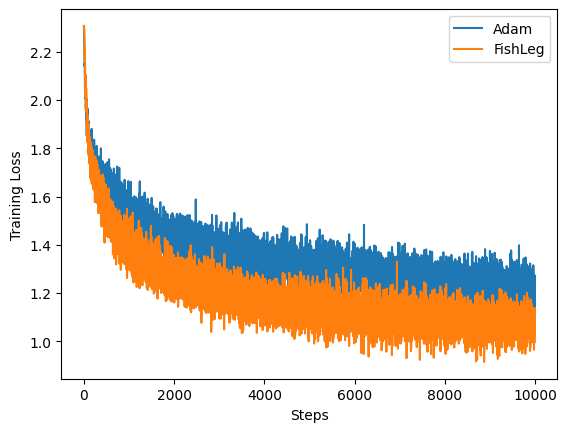

In [26]:
plt.plot(adam_train_df_per_step['loss'], label="Adam")
plt.plot(fishleg_train_df_per_step['loss'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Training Accuracy')

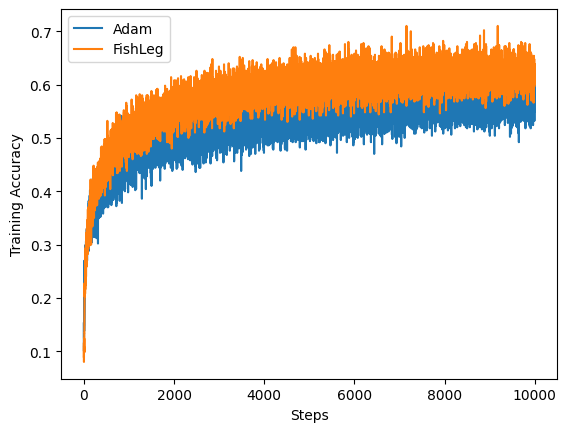

In [27]:
plt.plot(adam_train_df_per_step['acc'], label="Adam")
plt.plot(fishleg_train_df_per_step['acc'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Training Accuracy")

Text(0, 0.5, 'Training Loss')

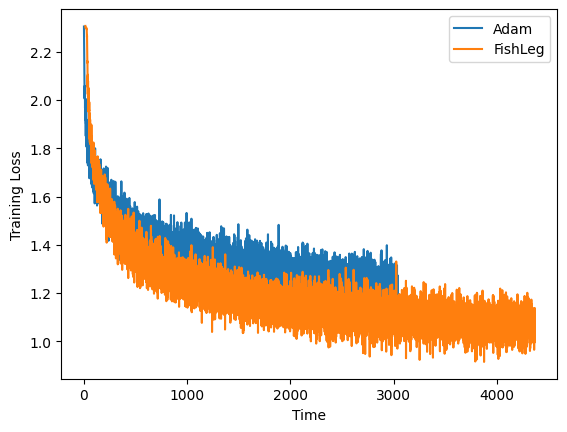

In [28]:
plt.plot(adam_train_df_per_step['step_time'], adam_train_df_per_step['loss'], label="Adam")
plt.plot(fishleg_train_df_per_step['step_time'], fishleg_train_df_per_step['loss'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Training Accuracy')

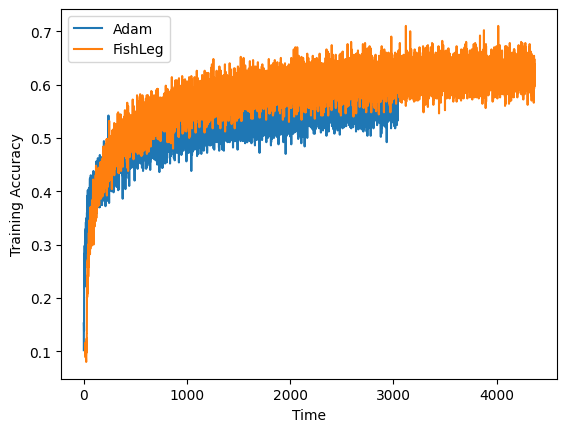

In [29]:
plt.plot(adam_train_df_per_step['step_time'], adam_train_df_per_step['acc'], label="Adam")
plt.plot(fishleg_train_df_per_step['step_time'], fishleg_train_df_per_step['acc'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training Accuracy")

Text(0, 0.5, 'Loss')

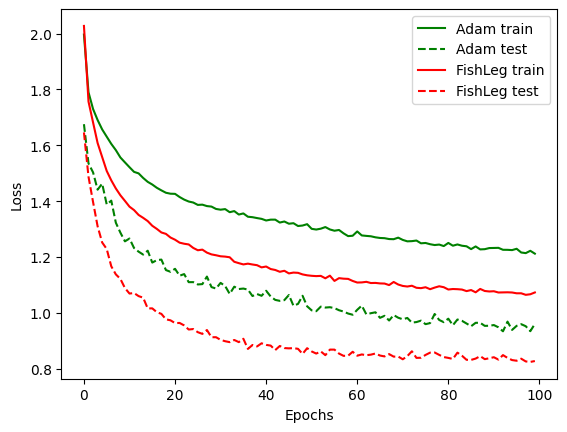

In [30]:
plt.plot(adam_df_per_epoch['train_loss'], 'g-', label="Adam train")
plt.plot(adam_df_per_epoch['test_loss'],'g--',label="Adam test")
plt.plot(fishleg_df_per_epoch['train_loss'], 'r-', label="FishLeg train")
plt.plot(fishleg_df_per_epoch['test_loss'], 'r--',label="FishLeg test")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

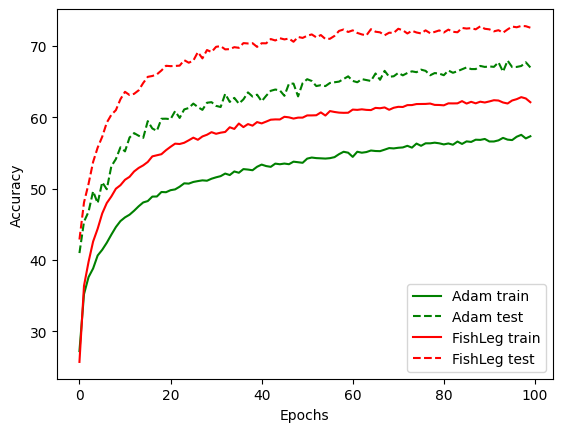

In [31]:
plt.plot(adam_df_per_epoch['train_acc'], 'g-', label="Adam train")
plt.plot(adam_df_per_epoch['test_acc'], 'g--', label="Adam test")
plt.plot(fishleg_df_per_epoch['train_acc'], 'r-', label="FishLeg train")
plt.plot(fishleg_df_per_epoch['test_acc'], 'r--', label="FishLeg test")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Training loss')

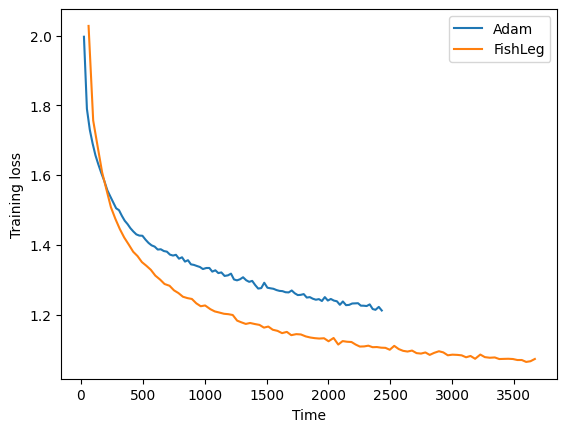

In [32]:
plt.plot(adam_df_per_epoch['epoch_time'], adam_df_per_epoch['train_loss'], label="Adam")
plt.plot(fishleg_df_per_epoch['epoch_time'], fishleg_df_per_epoch['train_loss'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training loss")

Text(0, 0.5, 'Training accuracy')

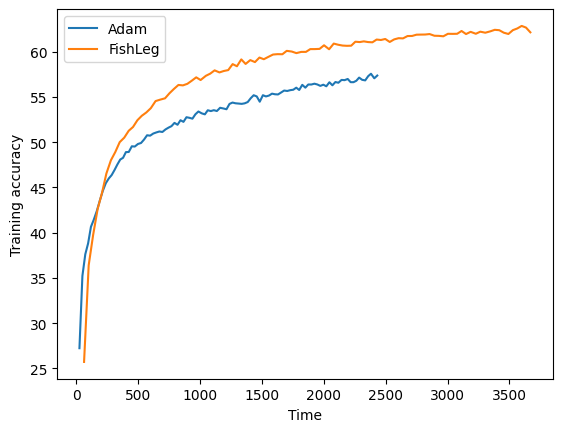

In [33]:
plt.plot(adam_df_per_epoch['epoch_time'], adam_df_per_epoch['train_acc'], label="Adam")
plt.plot(fishleg_df_per_epoch['epoch_time'], fishleg_df_per_epoch['train_acc'], label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training accuracy")

## Discussion
As displayed, with FishLeg optimiser, we are able to converge quicker in comparison to Adam optimiser.

# Auxiliary Loss

To better understand the operation of FishLeg, we could also plot the auxiliary loss throughout the training.

Text(0, 0.5, 'Auxiliary loss')

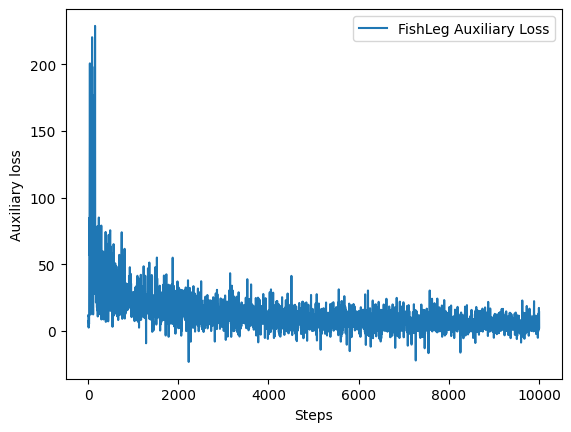

In [34]:
plt.plot(fishleg_train_df_per_step['aux_loss'], label="FishLeg Auxiliary Loss")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Auxiliary loss")

Text(0, 0.5, 'Auxiliary loss')

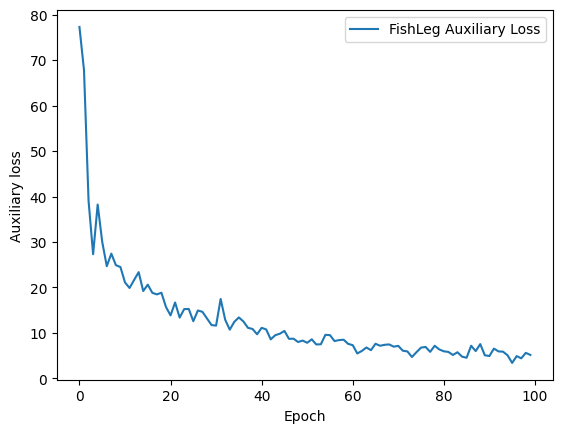

In [35]:
plt.plot(fishleg_df_per_epoch['aux_loss'], label="FishLeg Auxiliary Loss")
plt.legend(loc='best')
plt.xlabel("Epoch")
plt.ylabel("Auxiliary loss")